<a href="https://colab.research.google.com/github/VaishnaviBairagoni/NLP-LAB/blob/main/(NLP-F-29-08-2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Dataset shape: (20, 3)
   id                                               text  target
0   1  Massive earthquake in California, buildings co...       1
1   2  Flash flood warning in Houston—roads submerged...       1
2   3  Wildfire approaching the town; heavy smoke and...       1
3   4  Aftershock reported near Tokyo, power lines do...       1
4   5  Bridge washed out after heavy rains, stranded ...       1


/tmp/ipython-input-3005305161.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='Set2')


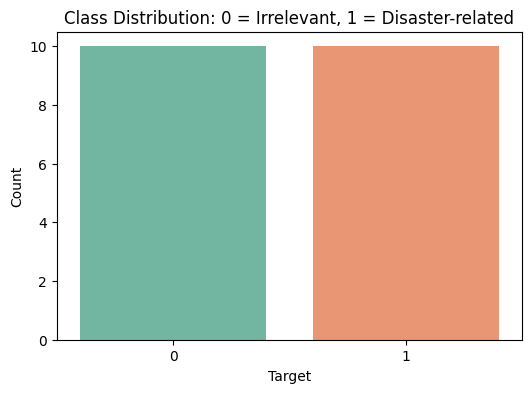

In [2]:
#Load the dataset
df = pd.read_csv("/content/disaster_tweets_sample.csv")  # Update path if needed
print("Dataset shape:", df.shape)
print(df.head())

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Class Distribution: 0 = Irrelevant, 1 = Disaster-related")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [3]:
# Display random 3 disaster tweets and 3 irrelevant tweets
print("\nSample Disaster-Related Tweets:")
print(df[df['target'] == 1]['text'].sample(3, random_state=42).tolist())

print("\nSample Irrelevant Tweets:")
print(df[df['target'] == 0]['text'].sample(3, random_state=42).tolist())



Sample Disaster-Related Tweets:
['Train derailment causing chemical spill; authorities urge evacuation.', 'Flash flood warning in Houston—roads submerged, rescue boats heading out now.', 'Tornado touched down outside Oklahoma City, homes damaged and injuries reported.']

Sample Irrelevant Tweets:
['Monday again… send coffee.', 'Love this movie—what a rollercoaster of emotions!', 'Weather is nice today—finally some sunshine!']


In [14]:
#Section B: Data Preprocessing and Cleaning
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to reduce elongated words (e.g., sooooo -> soo)
def reduce_elongation(word):
    return re.sub(r"(.)\1{2,}", r"\1\1", word)
# Cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [reduce_elongation(w) for w in tokens if w not in stop_words and w not in string.punctuation]
    return tokens

# Test cleaning
print("\nCleaning example:")
print(clean_text("Sooo manyyyy floods happening!!!"))

# Apply cleaning for normalization test
sample_texts = df['text'].head(5).tolist()
records = []
for txt in sample_texts:
    tokens = clean_text(txt)
    stemmed = [ps.stem(w) for w in tokens]
    lemmatized = [lemmatizer.lemmatize(w) for w in tokens]
    records.append({"Original": txt, "Stemmed": " ".join(stemmed), "Lemmatized": " ".join(lemmatized)})

print("\nStemming vs Lemmatization (First 5 Tweets):")
compare_df = pd.DataFrame(records)
print(compare_df)




Cleaning example:
['soo', 'manyy', 'floods', 'happening']

Stemming vs Lemmatization (First 5 Tweets):
                                            Original  \
0  Massive earthquake in California, buildings co...   
1  Flash flood warning in Houston—roads submerged...   
2  Wildfire approaching the town; heavy smoke and...   
3  Aftershock reported near Tokyo, power lines do...   
4  Bridge washed out after heavy rains, stranded ...   

                                             Stemmed  \
0  massiv earthquak california build collaps peop...   
1  flash flood warn houstonroad submerg rescu boa...   
2   wildfir approach town heavi smoke evacu underway   
3  aftershock report near tokyo power line fire r...   
4  bridg wash heavi rain strand famili near river...   

                                          Lemmatized  
0  massive earthquake california building collaps...  
1  flash flood warning houstonroads submerged res...  
2  wildfire approaching town heavy smoke evacuati...  
3 

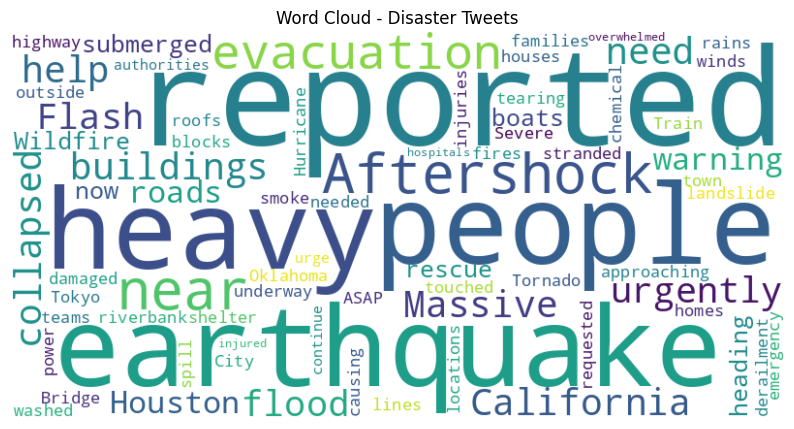

In [10]:
#Section C: Exploitary Analysis
# Q4: Word Cloud for disaster tweets
disaster_text = " ".join(df[df['target'] == 1]['text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Disaster Tweets")
plt.show()

/tmp/ipython-input-614275680.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='coolwarm')


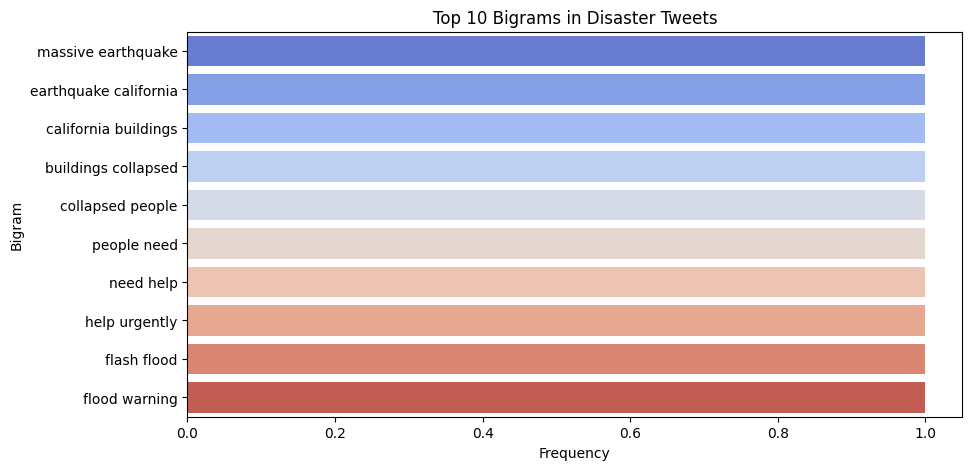

In [11]:
# Top 10 bigrams in disaster tweets
from sklearn.feature_extraction.text import CountVectorizer
disaster_tweets = df[df['target'] == 1]['text']
cv = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = cv.fit_transform(disaster_tweets)
sum_bigrams = bigrams.sum(axis=0)
bigram_freq = [(word, sum_bigrams[0, idx]) for word, idx in cv.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(10, 5))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='coolwarm')
plt.title("Top 10 Bigrams in Disaster Tweets")
plt.show()

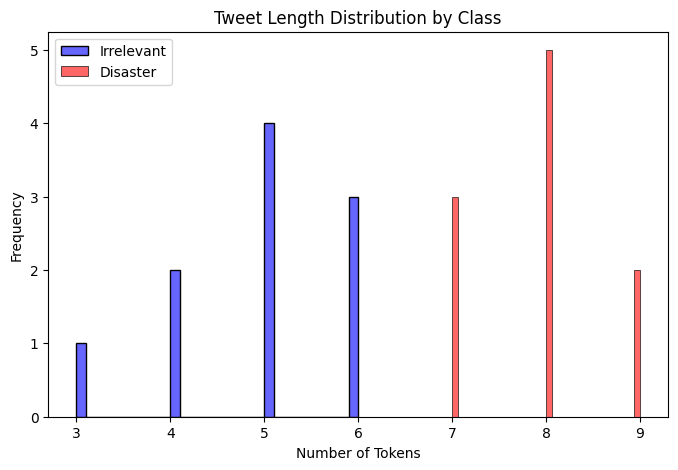

Average length of irrelevant tweets: 4.9
Average length of disaster tweets: 7.9


In [12]:
# Q5: Length distribution
df['tokens'] = df['text'].apply(lambda x: clean_text(x))
df['length'] = df['tokens'].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df[df['target'] == 0]['length'], bins=30, color='blue', label='Irrelevant', alpha=0.6)
sns.histplot(df[df['target'] == 1]['length'], bins=30, color='red', label='Disaster', alpha=0.6)
plt.legend()
plt.title("Tweet Length Distribution by Class")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

print("Average length of irrelevant tweets:", df[df['target']==0]['length'].mean())
print("Average length of disaster tweets:", df[df['target']==1]['length'].mean())



Logistic Regression Metrics:
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.5000
F1 Score: 0.6667

Naive Bayes Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Random Forest Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


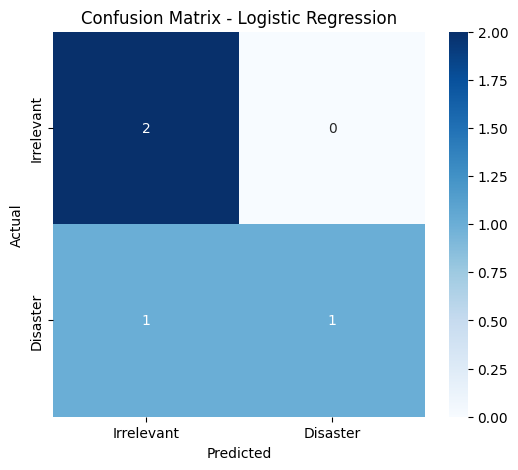

In [13]:
#Section D: Feature Extraction and Modeling
# Prepare data
df['clean_text'] = df['tokens'].apply(lambda x: " ".join(x))
X = df['clean_text']
y = df['target']

# TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Random Forest (Optional)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation function
def evaluate_model(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return acc, f1

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_nb, "Naive Bayes")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Confusion Matrix for best model (choose Logistic Regression as baseline)
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Irrelevant', 'Disaster'], yticklabels=['Irrelevant', 'Disaster'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()